## What we did first was to source for a larger dataset with over 1000 rows and over 10 columns meeting the our Lecturers requirements which enable us carry out our Predictive Analysis precisely

## Project Topic: Predicting Income Level Using U.S. Census Data
## Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/adult)  
## Group 9 – CSIS 503 Data Science & Analytics Capstone Project

## We imported all the essential libraries required for data manipulation, visualization, preprocessing, modeling, evaluation, class balancing, and model interpretability in our income prediction project.

In [73]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modeling and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
)

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Handling class imbalance
from imblearn.over_sampling import SMOTE

# Interpretability
import shap

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Visual style
sns.set(style='whitegrid')
%matplotlib inline

# Create output folder for saving plots
import os
output_dir = r"C:\Users\User\Desktop\Group 9\Charts"
os.makedirs(output_dir, exist_ok=True)

## This is the preprocessing stage where we loaded and merged the training and test datasets, performed initial cleaning, and created a binary target column (is_high_income) for income classification. This was done before proceeding to full data cleaning and feature engineering.

In [74]:
## This is the Preprocessing Stage Where We Loaded the datasets and merged them, cleaned, and merged training and test datasets into one DataFrame with a binary target column for income classification before We Started Full Cleaning and Feature Engineering # Define column names
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

# Load the training dataset
df_train = pd.read_csv(
    "C:/Users/user/Downloads/adult/adult.csv",
    names=columns,
    header=None,
    skipinitialspace=True,
    na_values="?"
)

# Load the test dataset
df_test = pd.read_csv(
    "C:/Users/user/Downloads/adult/adult_test.csv",
    names=columns,
    header=None,
    skiprows=1,
    skipinitialspace=True,
    na_values="?"
)

# Clean the test set's target column
df_test["income"] = df_test["income"].str.replace(".", "", regex=False).str.strip()

# Label sources
df_train["source"] = "train"
df_test["source"] = "test"

# Combining the datasets into one DataFrame
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Creating a binary target column for modeling
df_combined['is_high_income'] = (df_combined['income'] == '>50K').astype(int)

# Preview the combined data
print(df_combined.shape)
print(df_combined['source'].value_counts())
print(df_combined['is_high_income'].value_counts())
df_combined.head()


(48842, 17)
source
train    32561
test     16281
Name: count, dtype: int64
is_high_income
0    37155
1    11687
Name: count, dtype: int64


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,source,is_high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,train,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train,0


## This block displays the summary statistics of the numerical features in the dataset, including count, mean, standard deviation, min, max, and quartile values.

In [3]:
df_combined.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,is_high_income
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


## This section completes the full data cleaning and feature engineering process in preparation for model training

In [75]:
# Load combined file
df_combined = pd.read_csv("C:/Users/user/Downloads/adult/adult_combined.csv")

# Strip whitespace in object columns
obj_cols = df_combined.select_dtypes(include='object').columns
df_combined[obj_cols] = df_combined[obj_cols].apply(lambda x: x.str.strip())

# Drop missing values
df_combined.dropna(inplace=True)

# Ensure 'age' is numeric
df_combined['age'] = pd.to_numeric(df_combined['age'], errors='coerce')
df_combined.dropna(subset=['age'], inplace=True)

# Bin age
bins = [16, 30, 45, 60, 100]
labels = ['18-30', '31-45', '46-60', '60+']
df_combined['age_group'] = pd.cut(df_combined['age'].astype(int), bins=bins, labels=labels)

# One-hot encode categorical variables
categorical_cols = [
    'workclass', 'education', 'marital_status', 'occupation',
    'relationship', 'race', 'sex', 'native_country', 'age_group'
]
df_combined = pd.get_dummies(df_combined, columns=categorical_cols, drop_first=True)

# Converting income to binary target
df_combined['is_high_income'] = (df_combined['income'] == '>50K').astype(int)

# dropping unused columns
df_combined.drop(['income', 'source'], axis=1, inplace=True)

# Save cleaned dataset
df_combined.to_csv("C:/Users/user/Downloads/adult/adult_combined_cleaned.csv", index=False)
print("Cleaning complete. Saved as 'adult_combined_cleaned.csv'. Ready for EDA and modeling.")

# Preview
df_combined.head()


Cleaning complete. Saved as 'adult_combined_cleaned.csv'. Ready for EDA and modeling.


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,is_high_income,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,age_group_31-45,age_group_46-60,age_group_60+
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,True,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,True,False,False,False,True,False
2,38,215646,9,0,0,40,0,False,True,False,...,False,False,False,False,True,False,False,True,False,False
3,53,234721,7,0,0,40,0,False,True,False,...,False,False,False,False,True,False,False,False,True,False
4,28,338409,13,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False


## Feature and Target Definition  
We defined our target variable `is_high_income`, which indicates whether an individual's income exceeds $50K.  
All other cleaned and engineered features were stored in `X`.

## Data Splitting  
We split the dataset into training and test sets using an 80-20 split while preserving class balance using stratification.  
This ensures that the proportion of high-income vs. low-income individuals remains consistent in both sets.


In [76]:
# Defining the target and features from the cleaned dataset
X = df_combined.drop("is_high_income", axis=1)
y = df_combined["is_high_income"]

# Splitting the dataset into 80% training and 20% testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Confirm the split sizes
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (36177, 99)
Testing set size: (9045, 99)


## Target Class Distribution Visualization
Before applying class balancing techniques like SMOTE, we visualized the distribution of the binary target variable (`is_high_income`). The chart clearly shows that the dataset is imbalanced, with significantly more samples in the <=50K class than >50K.


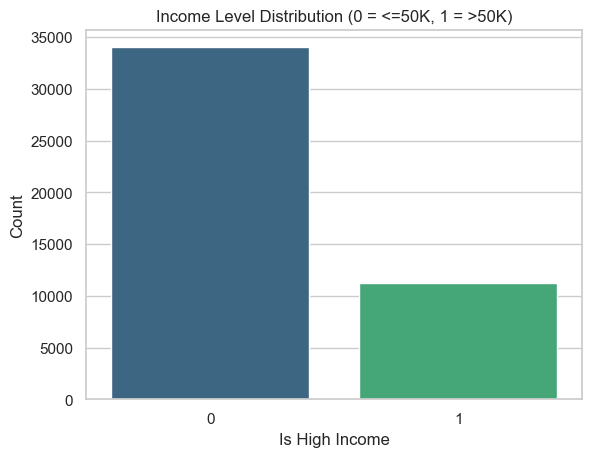

In [77]:
sns.countplot(x='is_high_income', data=df_combined, palette='viridis')
plt.title('Income Level Distribution (0 = <=50K, 1 = >50K)')
plt.xlabel('Is High Income')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, "income_level_by_distribution.png"))
plt.show()

## Handling Class Imbalance with SMOTE
To address class imbalance in the training set, we applied SMOTE (Synthetic Minority Over-sampling Technique). SMOTE generates synthetic examples of the minority class to create a more balanced training dataset and improve model generalization.


In [78]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training data to balance classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display the new class distribution after SMOTE
print("Class distribution after applying SMOTE:")
print(y_train_smote.value_counts())


Class distribution after applying SMOTE:
is_high_income
0    27211
1    27211
Name: count, dtype: int64


## Advanced Feature Engineering with Polynomial Features

### We applied polynomial feature transformation to numeric columns to help linear models capture nonlinear interactions and improve performance. This adds squared terms and cross-feature interactions to the dataset.


In [79]:
from sklearn.preprocessing import PolynomialFeatures

# Define numeric columns to generate interaction terms
numeric_features = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']

# Initialize PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform on training data, transform on test data
X_train_poly = poly.fit_transform(X_train_smote[numeric_features])
X_test_poly = poly.transform(X_test[numeric_features])  # Use transform only on test

# Display new shape and feature names
print("Polynomial Feature Expansion Completed.")
print("Original features:", len(numeric_features))
print("New features generated:", X_train_poly.shape[1])
print("Feature names:\n", poly.get_feature_names_out(numeric_features))




Polynomial Feature Expansion Completed.
Original features: 5
New features generated: 20
Feature names:
 ['age' 'education_num' 'hours_per_week' 'capital_gain' 'capital_loss'
 'age^2' 'age education_num' 'age hours_per_week' 'age capital_gain'
 'age capital_loss' 'education_num^2' 'education_num hours_per_week'
 'education_num capital_gain' 'education_num capital_loss'
 'hours_per_week^2' 'hours_per_week capital_gain'
 'hours_per_week capital_loss' 'capital_gain^2'
 'capital_gain capital_loss' 'capital_loss^2']


## Exploratory Data Analysis (EDA) Visualizations
### Correlation Heatmap

### Heatmap Analysis Approach

To perform a comprehensive correlation analysis, we employed two levels of heatmaps:

1. **Full Numeric Heatmap**  
   We computed a full correlation matrix including all numeric features (e.g., continuous variables and one-hot encoded dummies). While comprehensive, the visual output was dense and harder to interpret.

2. **Key Feature Heatmap (with Target)**  
   For clarity and insight, we created a refined heatmap including only the most relevant numerical predictors (`age`, `education_num`, `capital_gain`, `capital_loss`, `hours_per_week`) along with the target variable `is_high_income`. This allowed us to focus on the most influential relationships for model development.

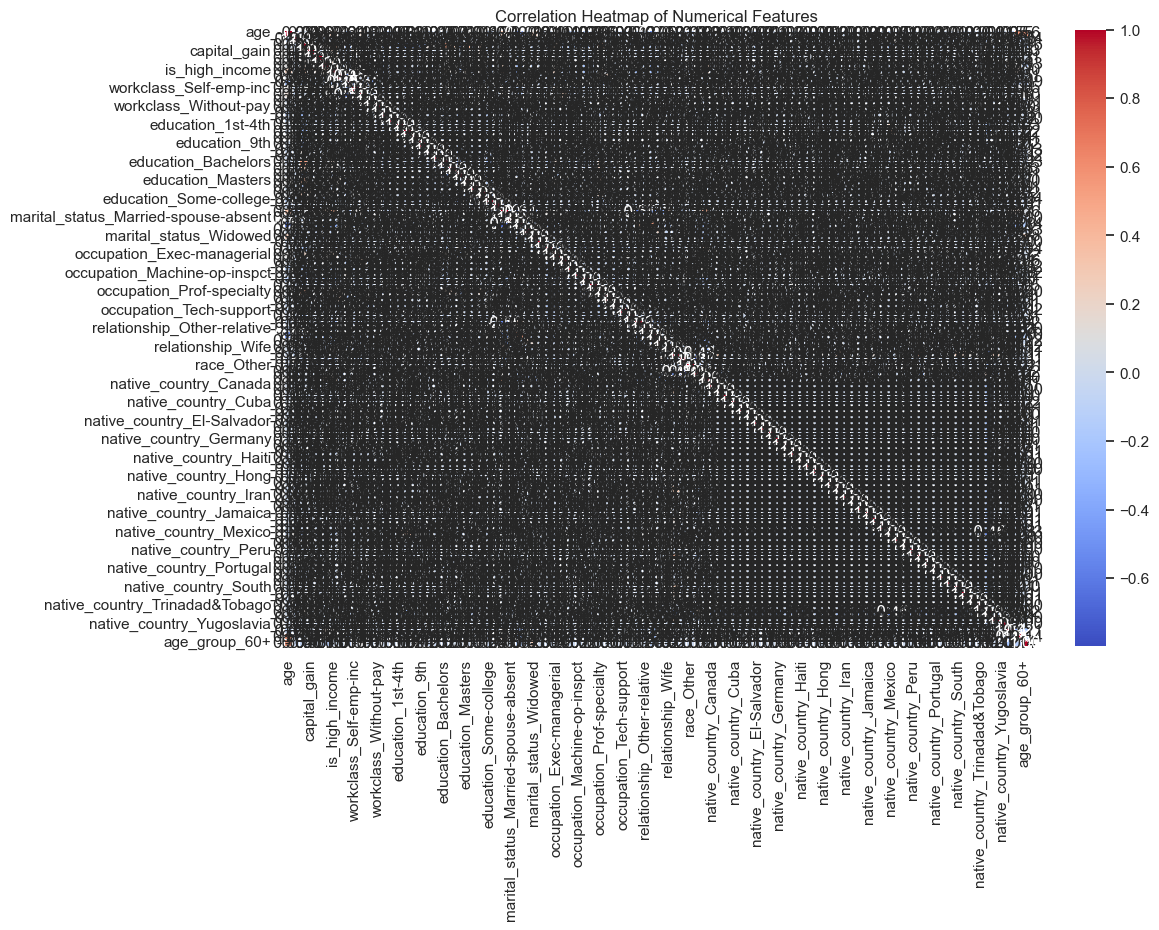

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (excluding the target)
corr = df_combined.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.savefig(os.path.join(output_dir, "correlation_heatmap.png"))
plt.show()

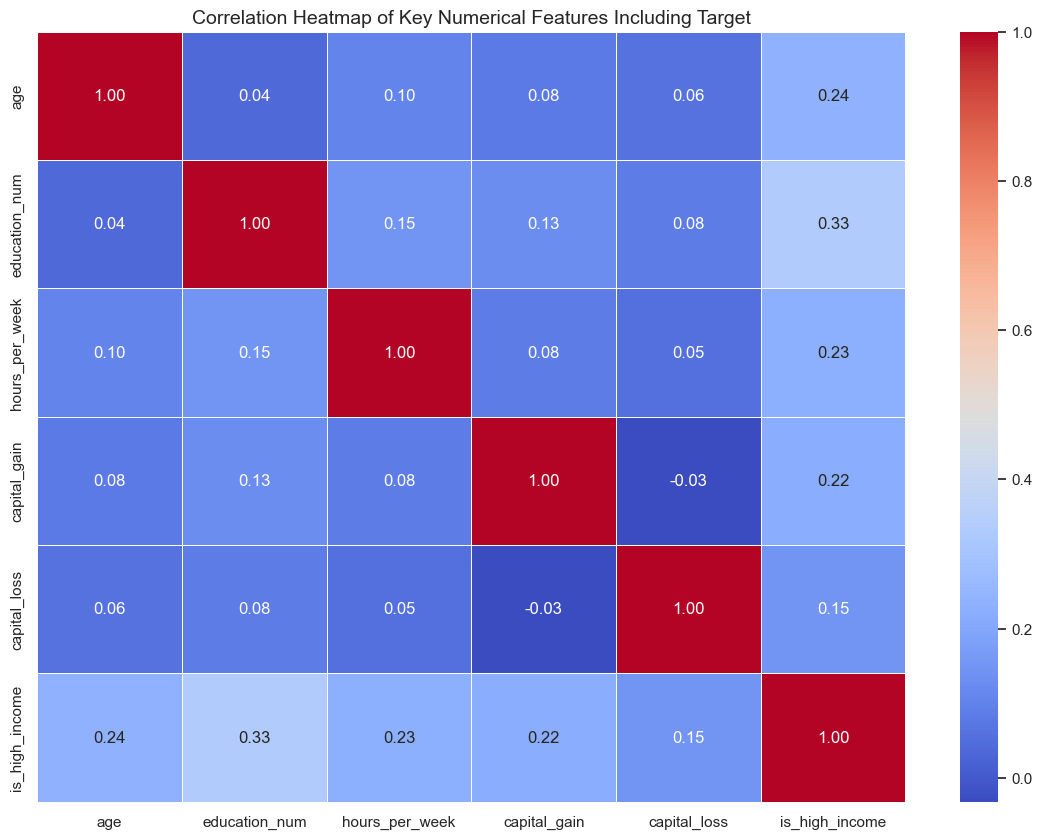

In [82]:
# Correlation Heatmap of Key Numerical Features Including Target 

# key numeric features
key_features_with_target = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss', 'is_high_income']

# Compute correlation matrix
corr_matrix = df_combined[key_features_with_target].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap of Key Numerical Features Including Target", fontsize=14)
plt.savefig(os.path.join(output_dir, "key_feature_heatmap.png"))
plt.show()


### Bar Plot: High-Income Proportions by Education Level

### We plotted the proportion of individuals earning more than $50K for each education category. 

### This barplot provides visual evidence of how higher education levels are generally associated with a higher likelihood of earning above $50K.

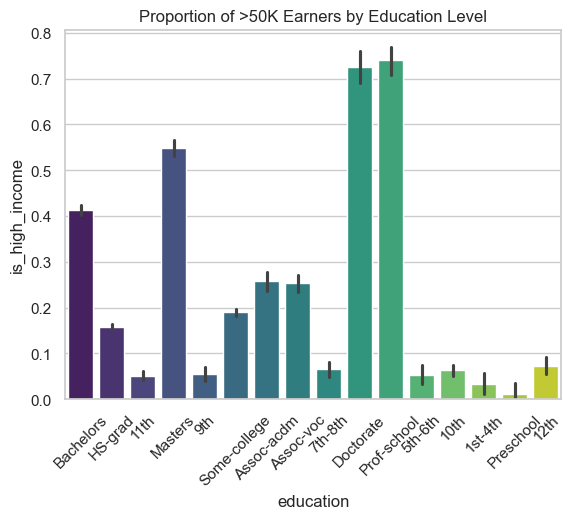

In [83]:
df_original = pd.read_csv("C:/Users/user/Downloads/adult/adult_combined.csv")
df_original['is_high_income'] = (df_original['income'] == '>50K').astype(int)

sns.barplot(x='education', y='is_high_income', data=df_original, estimator=lambda x: sum(x)/len(x), palette='viridis')
plt.xticks(rotation=45)
plt.title("Proportion of >50K Earners by Education Level")
plt.savefig(os.path.join(output_dir, "education_vs_income.png"))
plt.show()


### Boxplot of Age by Income Class
This boxplot shows the distribution of ages for low-income and high-income individuals. It reveals differences in age patterns between income groups.

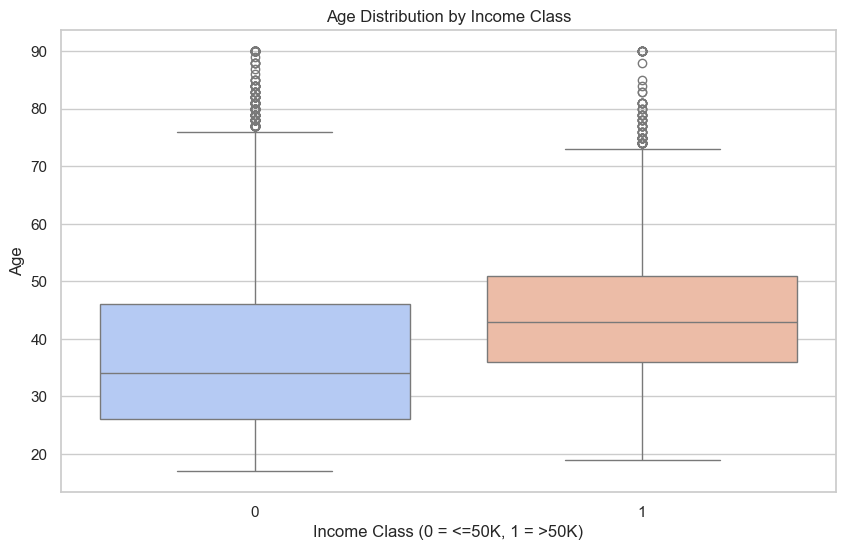

In [85]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_high_income', y='age', data=df_combined, palette='coolwarm')
plt.title("Age Distribution by Income Class")
plt.xlabel("Income Class (0 = <=50K, 1 = >50K)")
plt.ylabel("Age")
plt.savefig(os.path.join(output_dir, "Age_vs_income.png"))
plt.show()

## Work Hours Distribution by Income
## This histogram visualizes how working hours vary between income groups. High earners tend to work more hours per week on average.

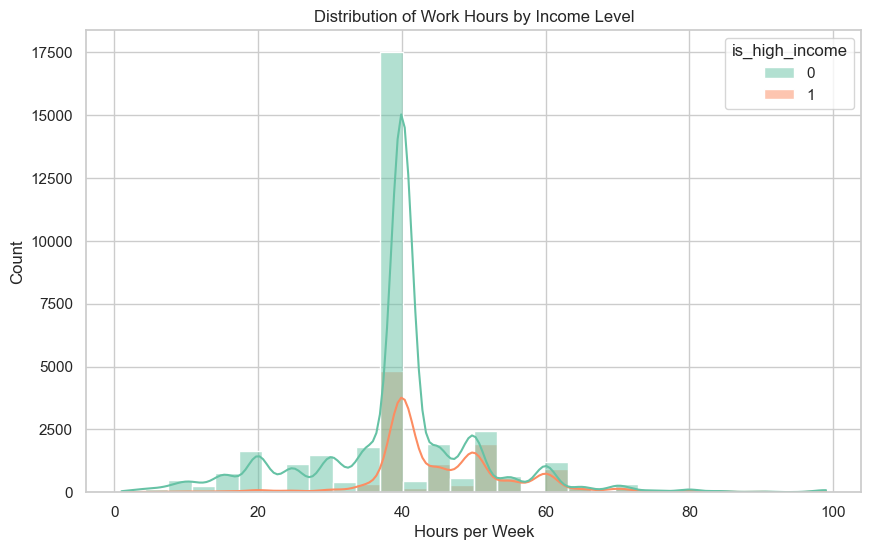

In [86]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_combined, x='hours_per_week', hue='is_high_income', bins=30, kde=True, palette='Set2')
plt.title("Distribution of Work Hours by Income Level")
plt.xlabel("Hours per Week")
plt.ylabel("Count")
plt.savefig(os.path.join(output_dir, "Work_hours_vs_income.png"))
plt.show()

## Occupation vs. Income Level
### This countplot shows how income levels are distributed across different occupations. Certain roles have more high-income earners than others.

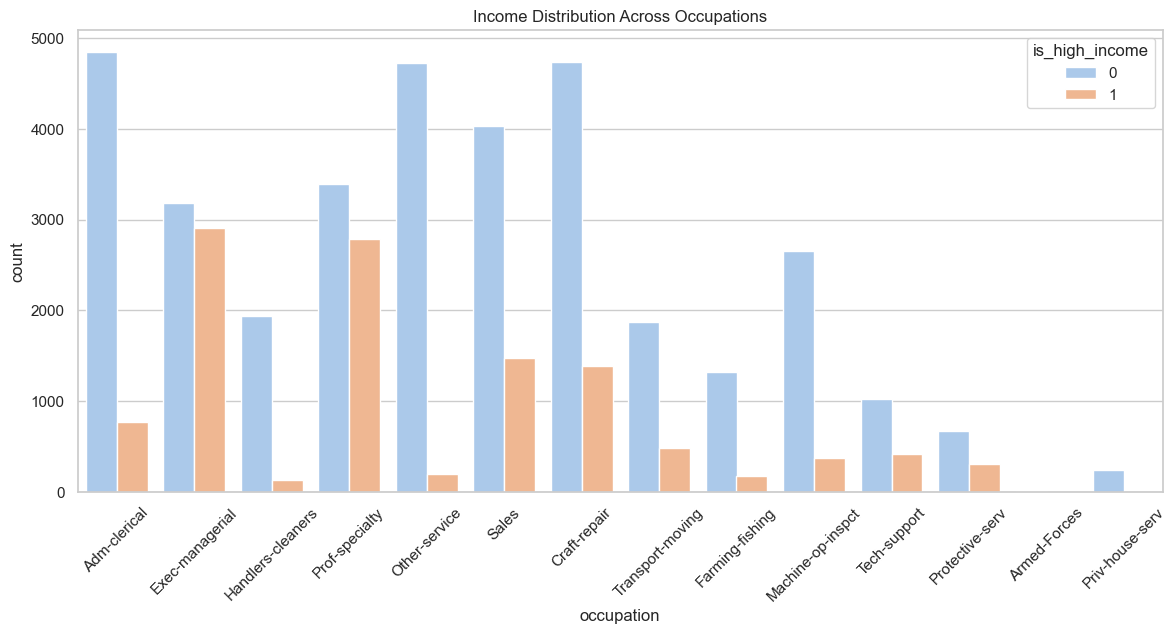

In [87]:
# Re-loading original (uncoded) version of the dataset
df_original = pd.read_csv("C:/Users/user/Downloads/adult/adult_combined.csv")

# Add the binary target
df_original['is_high_income'] = (df_original['income'] == '>50K').astype(int)

# Plot countplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.countplot(data=df_original, x='occupation', hue='is_high_income', palette='pastel')
plt.xticks(rotation=45)
plt.title("Income Distribution Across Occupations")
plt.savefig(os.path.join(output_dir, "Occupation_vs_income.png"))
plt.show()

## Gender vs. High Income

### To generate visualizations involving original categorical variables (like 'sex'), we reloaded a clean copy of the dataset before one-hot encoding. This ensured that features such as sex, race, and education were still available for visual exploration.

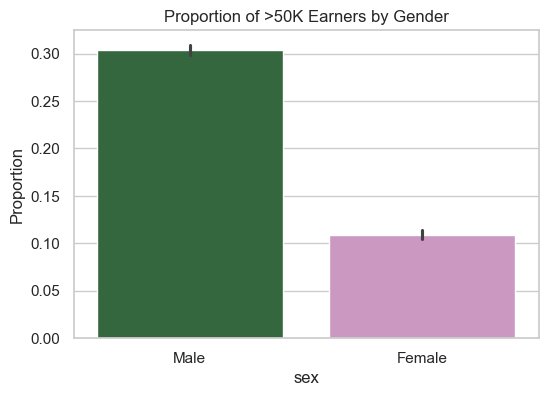

In [88]:
# We re-loaded a copy that still has the original 'sex' column
df_original = pd.read_csv("C:/Users/user/Downloads/adult/adult_combined.csv")
df_original['is_high_income'] = (df_original['income'] == '>50K').astype(int)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x='sex', y='is_high_income', data=df_original, estimator=lambda x: sum(x)/len(x), palette='cubehelix')
plt.title("Proportion of >50K Earners by Gender")
plt.ylabel("Proportion")
plt.savefig(os.path.join(output_dir, "Gender_vs_income.png"))
plt.show()


## Stage 6: Exploratory Data Analysis (EDA)

### We used various visualizations to understand relationships in the dataset:

- Correlation heatmap for numeric features
- Bar plots showing income proportion by education and gender
- Boxplot of hours per week by income
- Countplots for occupation distributions
- Histogram showing Age Distribution by Income Class
- Histograms and boxplots to examine work hours and age
- Capital gain and Capital Loss

These insights help guide feature engineering, model selection, and balancing techniques.

## Boxplot Showing Income Earning By Hours per Week

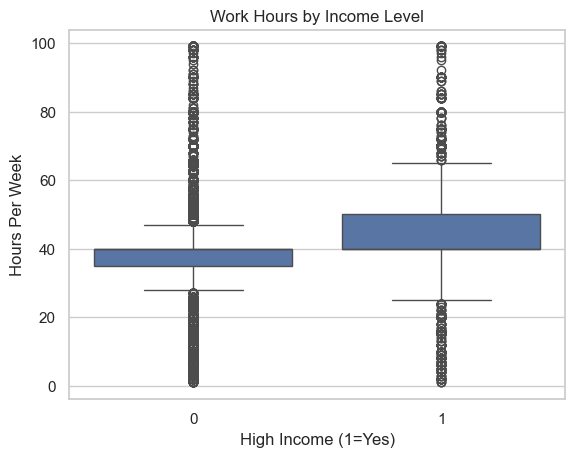

In [89]:
# Boxplot of hours per week by income
sns.boxplot(x='is_high_income', y='hours_per_week', data=df_original)
plt.title("Work Hours by Income Level")
plt.xlabel("High Income (1=Yes)")
plt.ylabel("Hours Per Week")
plt.savefig(os.path.join(output_dir, "Income_earning_by_hours_per_week.png"))
plt.show()

## Histogram showing how age varies between low and high income earners.

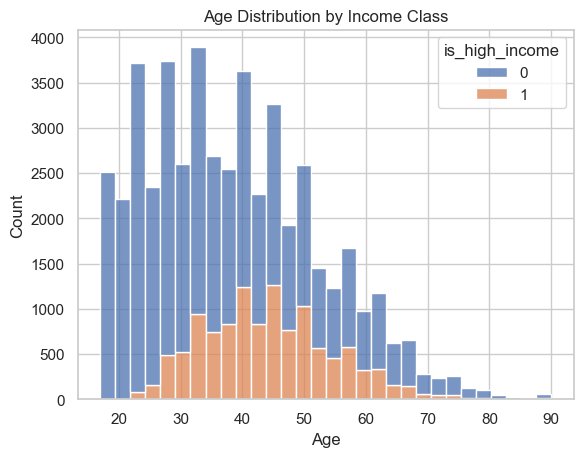

In [90]:
# Histogram of age
sns.histplot(data=df_original, x='age', bins=30, hue='is_high_income', multiple='stack')
plt.title("Age Distribution by Income Class")
plt.xlabel("Age")
plt.ylabel("Count")
plt.savefig(os.path.join(output_dir, "Age_distribution_by_income_class.png"))
plt.show()

## Pairplot Showing Key Features

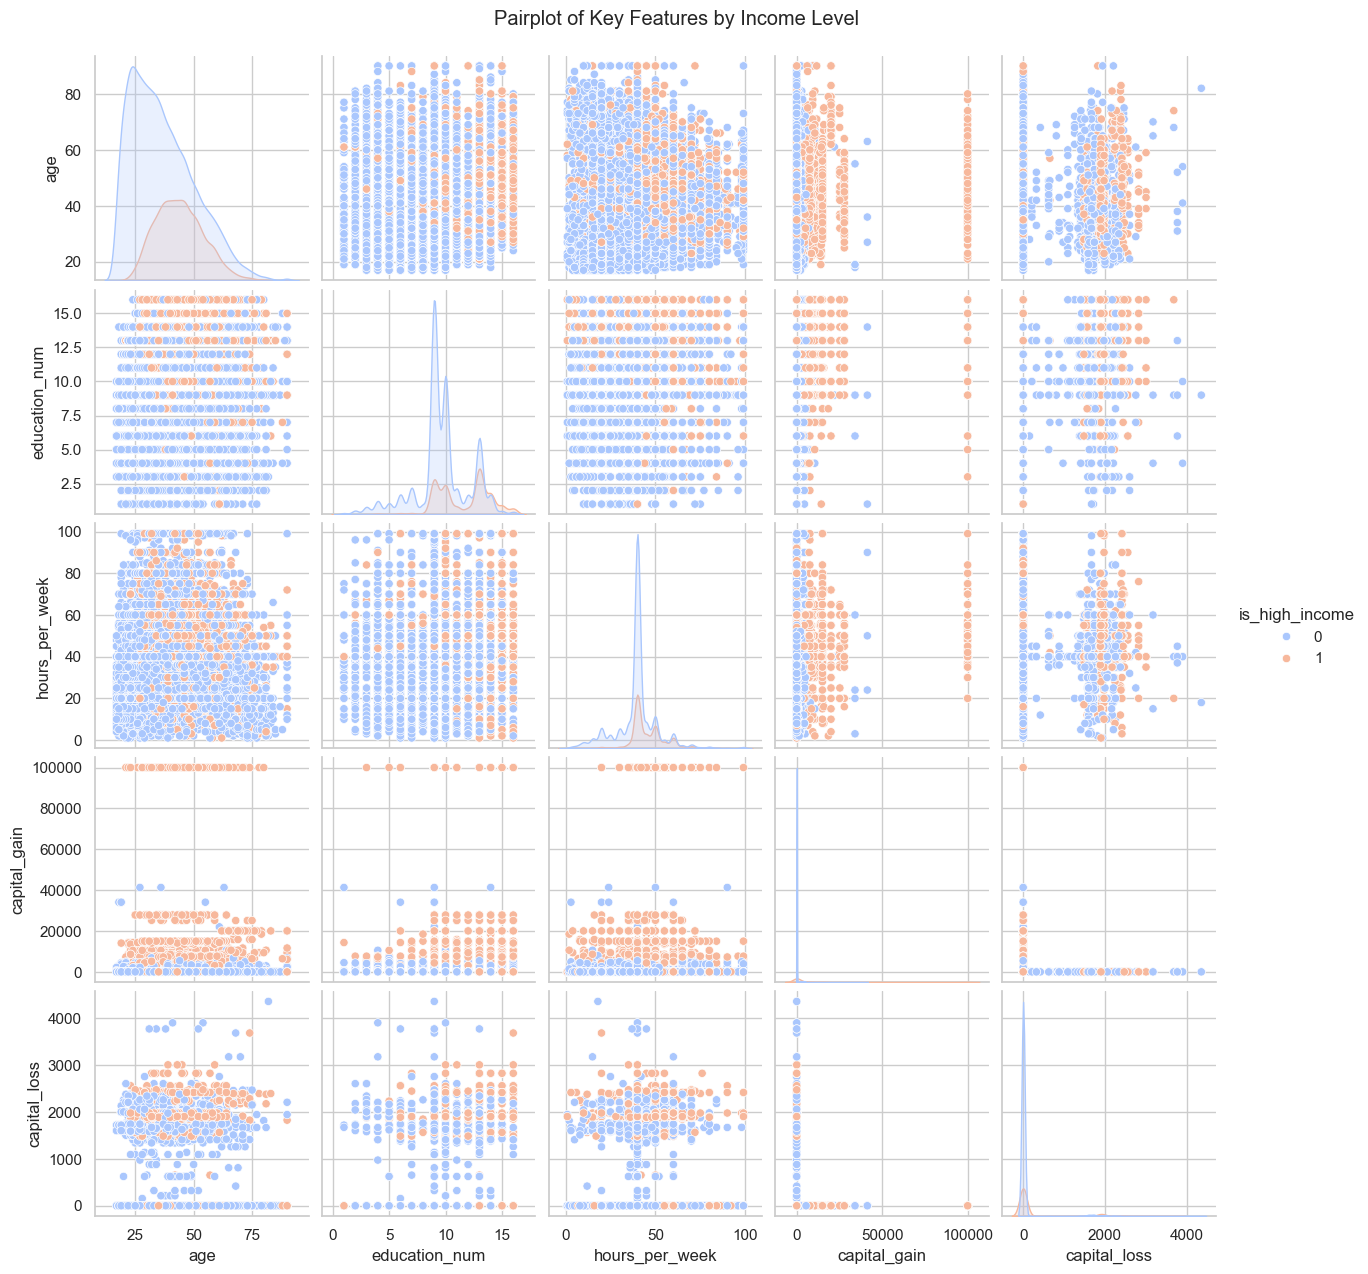

In [94]:
# Pairplot
selected_features = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss', 'is_high_income']
sns.pairplot(df_combined[selected_features], hue='is_high_income', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairplot of Key Features by Income Level', y=1.02)
plt.savefig(os.path.join(output_dir, "Pairplot_of_key_features.png"))
plt.show()

## Capital Gain and Loss Distribution

## We plotted histograms of 'capital_gain' and 'capital_loss' to understand their distribution. These features are highly right-skewed, with the majority of entries at zero and a few high-value outliers. This insight helps us decide whether transformation or scaling is needed before modeling.

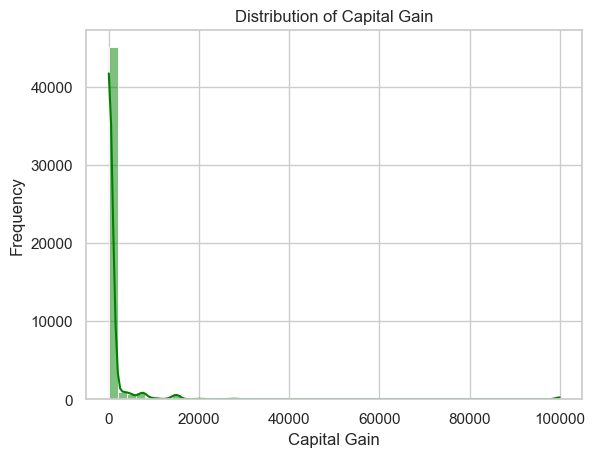

In [95]:
# Distribution of Capital Gain
# Capital gain is right-skewed; this histogram helps us inspect its sparsity and outliers.

sns.histplot(data=df_original, x='capital_gain', bins=50, kde=True, color='green')
plt.title("Distribution of Capital Gain")
plt.xlabel("Capital Gain")
plt.ylabel("Frequency")
plt.savefig(os.path.join(output_dir, "Distribution_of_capital_gain.png"))
plt.show()


## Distribution of Capital Loss

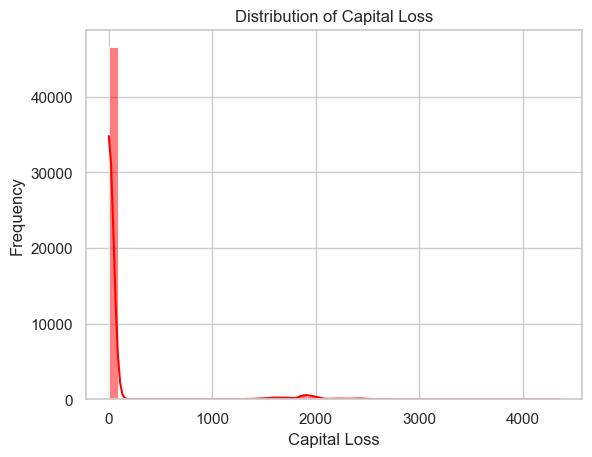

In [96]:
# Distribution of Capital Loss
# Similar to capital gain, capital loss is also skewed — this plot reveals its distribution.

sns.histplot(data=df_original, x='capital_loss', bins=50, kde=True, color='red')
plt.title("Distribution of Capital Loss")
plt.xlabel("Capital Loss")
plt.ylabel("Frequency")
plt.savefig(os.path.join(output_dir, "Distribution_of_capital_loss.png"))
plt.show()


## Log Transformation of Skewed Features

## The 'capital_gain' and 'capital_loss' features were highly skewed, with most values concentrated at zero and a few extreme outliers. To address this, we applied a log transformation using 'log1p()`, which computes 'log(1 + x)'. This transformation compressed large values and expanded smaller ones, reducing skewness and making the features more suitable for modeling.

## Below are the resulting distributions of the log-transformed features:
- 'log_capital_gain'
- 'log_capital_loss'

## These transformed features were used in subsequent heatmaps and model training.


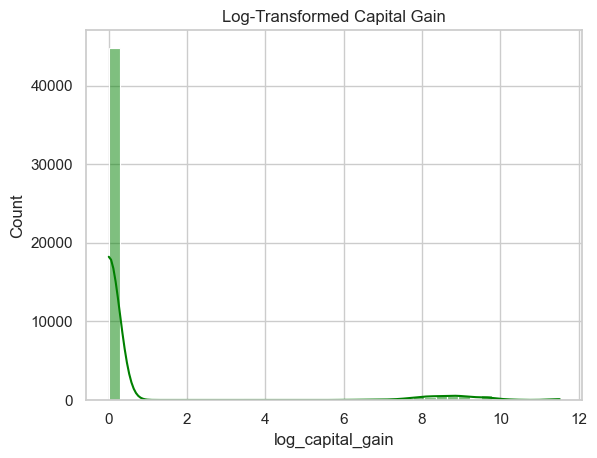

In [97]:
import numpy as np

# Apply log(1 + x) to avoid log(0) issues
df_original['log_capital_gain'] = np.log1p(df_original['capital_gain'])
df_original['log_capital_loss'] = np.log1p(df_original['capital_loss'])

# Plot the transformed feature
sns.histplot(df_original['log_capital_gain'], bins=40, kde=True, color='green')
plt.title("Log-Transformed Capital Gain")
plt.savefig(os.path.join(output_dir, "Log_transformed_capital_gain.png"))
plt.show()

## Log-Transformed of Capital Gain

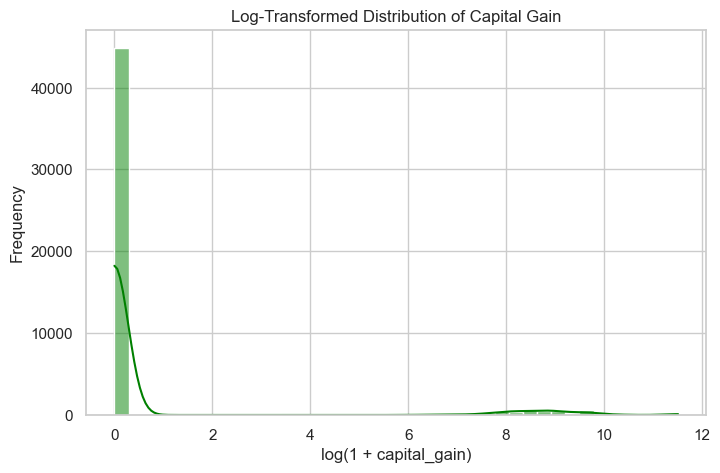

In [98]:
plt.figure(figsize=(8, 5))
sns.histplot(df_original['log_capital_gain'], bins=40, kde=True, color='green')
plt.title("Log-Transformed Distribution of Capital Gain")
plt.xlabel("log(1 + capital_gain)")
plt.ylabel("Frequency")
plt.savefig(os.path.join(output_dir, "Log_transformed_distribution_of_capital_gain.png"))
plt.show()


## Log-Transformed of Capital Loss

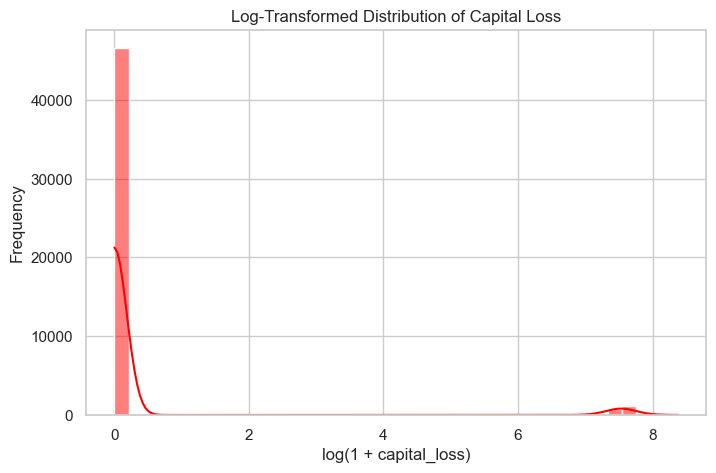

In [99]:
plt.figure(figsize=(8, 5))
sns.histplot(df_original['log_capital_loss'], bins=40, kde=True, color='red')
plt.title("Log-Transformed Distribution of Capital Loss")
plt.xlabel("log(1 + capital_loss)")
plt.ylabel("Frequency")
plt.savefig(os.path.join(output_dir, "Log_transformed_distribution_of_capital_loss.png"))
plt.show()


## Logistic Regression

We trained a Logistic Regression model on the SMOTE-balanced dataset. Performance was evaluated using classification metrics and the ROC curve. The model provides a baseline for comparison with more complex algorithms such as XGBoost.

- **ROC-AUC Score**: Indicates the model’s ability to distinguish between income classes.
- **Confusion Matrix**: Shows the breakdown of correct vs incorrect predictions.
- **Classification Report**: Provides precision, recall, and F1-score for both classes.


In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_lr))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      6803
           1       0.57      0.70      0.63      2242

    accuracy                           0.80      9045
   macro avg       0.73      0.76      0.75      9045
weighted avg       0.81      0.80      0.80      9045

Confusion Matrix:
 [[5630 1173]
 [ 669 1573]]
ROC AUC Score: 0.8665719903967435


## The classification report shows:
# - Class 0 (<=50K): High precision (0.89) and good recall (0.83), meaning the model is very good at identifying low-income individuals.
# - Class 1 (>50K): Lower precision (0.57) but decent recall (0.70), meaning the model captures most high-income individuals, but with more false positives.

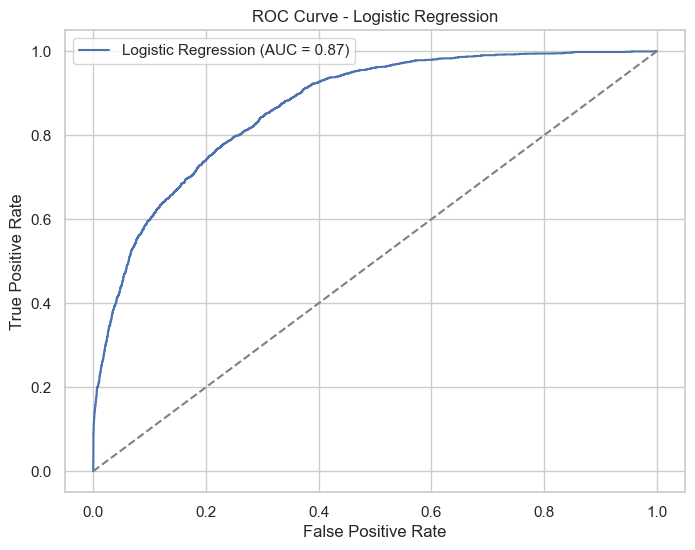

In [101]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="Logistic Regression (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob_lr)))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.savefig(os.path.join(output_dir, "ROC_curve_logistic_regression.png"))
plt.show()


## # ROC AUC Score: 0.867 — This is a strong performance.
# It means the model can distinguish between classes 86.7% of the time.

## XGBoost Model Evaluation

**We trained an XGBoost classifier on the SMOTE-balanced data to predict income levels. Below is the classification report, confusion matrix, and ROC AUC score for the model.**


In [102]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_smote, y_train_smote)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      6803
           1       0.74      0.68      0.71      2242

    accuracy                           0.86      9045
   macro avg       0.82      0.80      0.81      9045
weighted avg       0.86      0.86      0.86      9045

Confusion Matrix:
 [[6283  520]
 [ 725 1517]]
ROC AUC Score: 0.9205313668223457


## ROC Curve - XGBoost Classifier

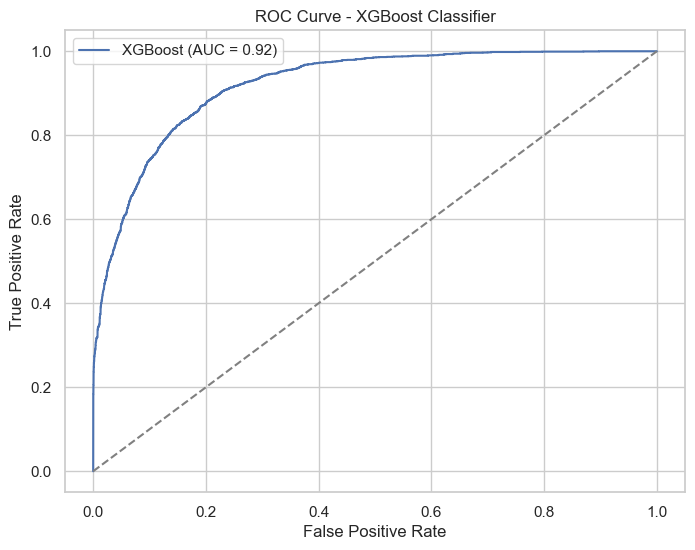

In [103]:
# Plot ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob_xgb)))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost Classifier")
plt.legend()
plt.savefig(os.path.join(output_dir, "ROC_curve_XGBOOST_classifier.png"))
plt.show()

## ROC AUC Score (XGBoost)

## The ROC AUC score for the XGBoost model was **0.9205**, indicating **excellent discriminative ability**. This means that the model can distinguish between high-income and low-income individuals with 92% accuracy in terms of class ranking. It significantly outperforms the baseline and also shows improvement over the Logistic Regression model used earlier.

## ROC Curve for XGBoost

## The ROC curve plots the true positive rate (sensitivity) against the false positive rate. The XGBoost model achieved an **AUC of 0.92**, indicating strong classification performance. The closer the curve follows the top-left border, the better the model's performance.

## This visualization confirms that the XGBoost model is highly effective in distinguishing between individuals earning more than $50K and those earning less.


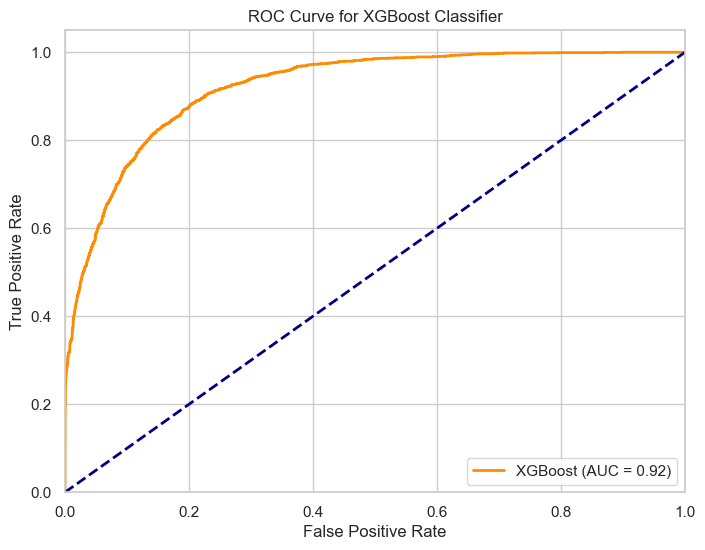

In [104]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(os.path.join(output_dir, "ROC_curve_for_XGBOOst_classifier.png"))
plt.show()


## Train-Test Split and Handling Class Imbalance with SMOTE

In [105]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Define features and target
X = df_combined.drop("is_high_income", axis=1)
y = df_combined["is_high_income"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_smote.value_counts())


After SMOTE:
is_high_income
0    27211
1    27211
Name: count, dtype: int64


## Modeling Block

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      6803
           1       0.69      0.64      0.66      2242

    accuracy                           0.84      9045
   macro avg       0.79      0.77      0.78      9045
weighted avg       0.84      0.84      0.84      9045

ROC-AUC: 0.8966126543584236


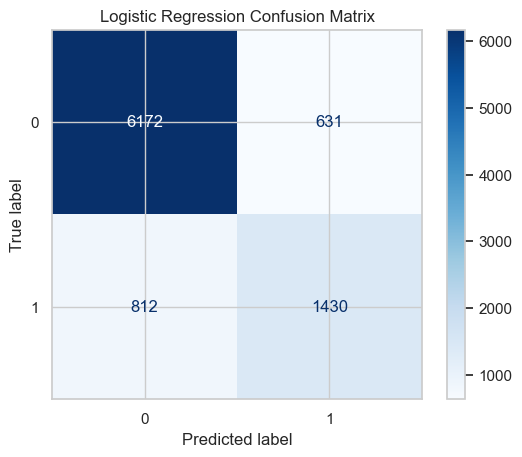

Random Forest Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6803
           1       0.71      0.65      0.68      2242

    accuracy                           0.85      9045
   macro avg       0.80      0.78      0.79      9045
weighted avg       0.84      0.85      0.84      9045

ROC-AUC: 0.8965339450520531


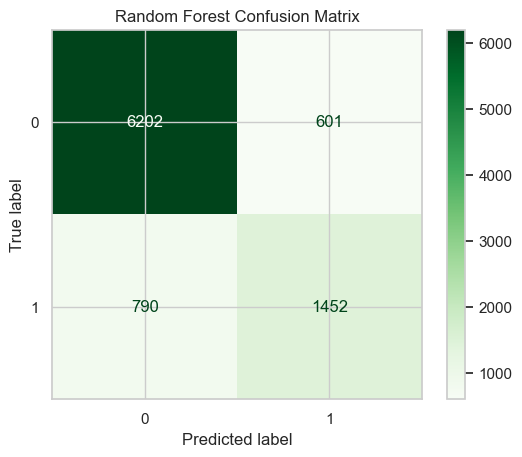

In [106]:
# Modeling Block

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import shap

# Split features and target
X = df_combined.drop('is_high_income', axis=1)
y = df_combined['is_high_income']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handling imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)
y_pred_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_lr))

ConfusionMatrixDisplay.from_estimator(lr, X_test_scaled, y_test, cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.savefig(os.path.join(output_dir, "Logistic_regression_confusion_matrix.png"))
plt.show()

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_rf))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.savefig(os.path.join(output_dir, "Random_forest_confusion_matrix.png"))
plt.show()


## This is the ROC Curve Comparison plot for both Models

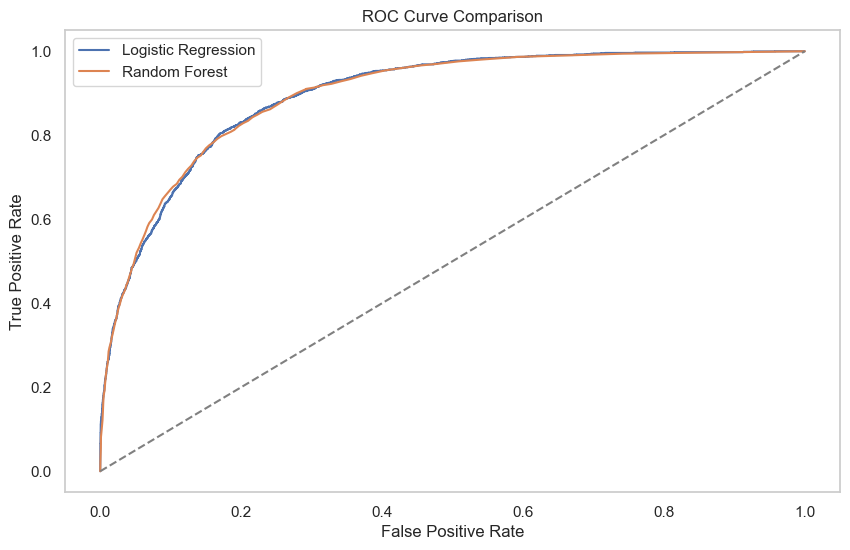

In [107]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, "ROC_curve_comparison_plot_for_both_models.png"))
plt.show()


## XGBoost Hyperparameter Tuning

In [108]:
# Training and Tuning XGBoost classifier 

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit the model on your SMOTE-resampled training data
grid_search_xgb.fit(X_train_res, y_train_res)

# Extract the best estimator for use in SHAP
best_xgb = grid_search_xgb.best_estimator_

# Evaluate quickly
print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best XGBoost ROC-AUC (CV):", grid_search_xgb.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best XGBoost ROC-AUC (CV): 0.9682074600668363


## XGBoost Hyperparameter Tuning Results

After running GridSearchCV on the SMOTE-resampled training data with 5-fold cross-validation, the best performing parameters were:

- `learning_rate': **0.1**
- `max_depth`: **5**
- `n_estimators`: **100**
- `subsample`: **1.0**

### Cross-Validation ROC-AUC Score:
- **0.9682** - This high score indicates that the tuned XGBoost model has strong discriminatory power on the resampled training data.

## We will now use the best estimator (`best_xgb`) to make predictions and proceed with SHAP analysis and evaluation on the test data.


## Evaluation of Tuned XGBoost Model on Test Data

We evaluated our tuned XGBoost model using the test dataset. The steps include:

- **Prediction of income classes** (0 = ≤50K, 1 = >50K)
- **Probability estimation** for ROC AUC calculation
- **Classification report** showing precision, recall, F1-score, and support
- **ROC AUC score** to assess the model's ability to separate classes
- **Confusion matrix** visualization for a clearer view of prediction accuracy

## This block helps us understand how well our tuned model generalizes to unseen data.

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6803
           1       0.72      0.68      0.70      2242

    accuracy                           0.85      9045
   macro avg       0.81      0.80      0.80      9045
weighted avg       0.85      0.85      0.85      9045

ROC AUC Score: 0.9156449317959765


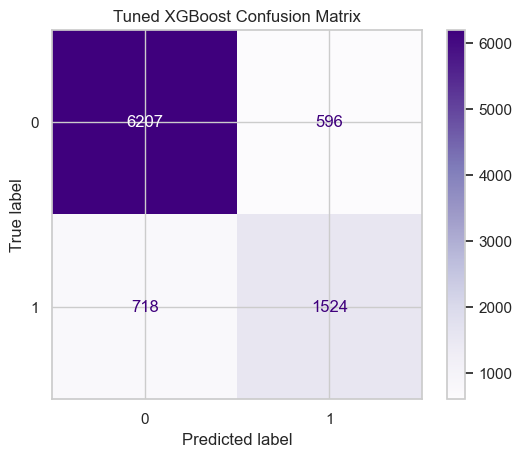

In [109]:
# Predict with best model
y_pred_best = best_xgb.predict(X_test)
y_prob_best = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_best))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_best))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, cmap='Purples')
plt.title("Tuned XGBoost Confusion Matrix")
plt.savefig(os.path.join(output_dir, "Evaluation_of_tuned_XGBoost_on_test_data.png"))
plt.show()

                              Feature  Importance
0                                 age    0.115850
1                              fnlwgt    0.093609
5                      hours_per_week    0.076516
30       marital_status_Never-married    0.071035
2                       education_num    0.066633
28  marital_status_Married-civ-spouse    0.063777
46         relationship_Not-in-family    0.058716
3                        capital_gain    0.054375
22                  education_HS-grad    0.042387
49             relationship_Unmarried    0.031088


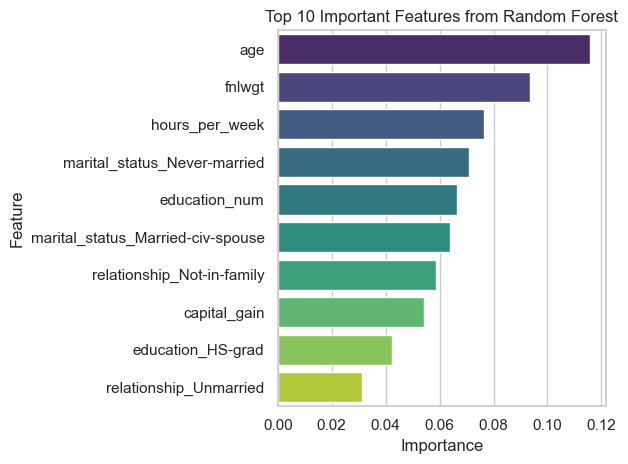

In [110]:
# Dropping Low Important Features

importances = rf.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importance_df.head(10))

# Bar Plot 
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Important Features from Random Forest")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Dropping_low_important_features.png"))
plt.show()

## SHAP Interpretation of Random Forest Model

### We applied SHAP (SHapley Additive exPlanations) to the Random Forest classifier to interpret how features influence the prediction of income levels. The test set was cleaned and converted to numeric to ensure SHAP compatibility. We then generated two key visualizations:

- **Bar plot: Shows the average impact of each feature on model output.**

- **Beeswarm plot: Illustrates the distribution and magnitude of feature effects across all predictions.**

- **These insights help us understand which features drive income classification the most.**



X_test_clean is fully numeric and ready for SHAP. Shape: (9045, 99)


100%|===================| 18089/18090 [34:32<00:00]        

SHAP values computed successfully.


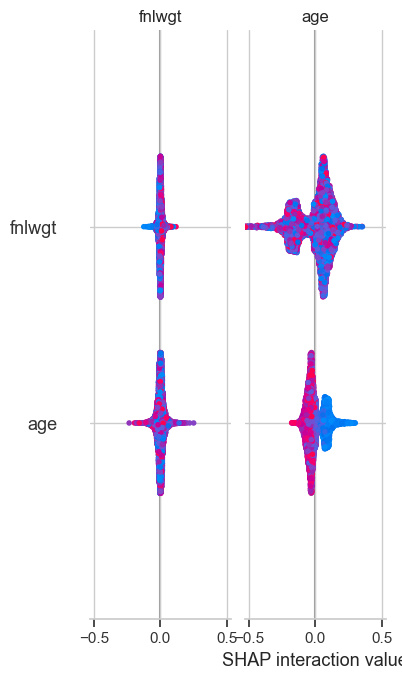

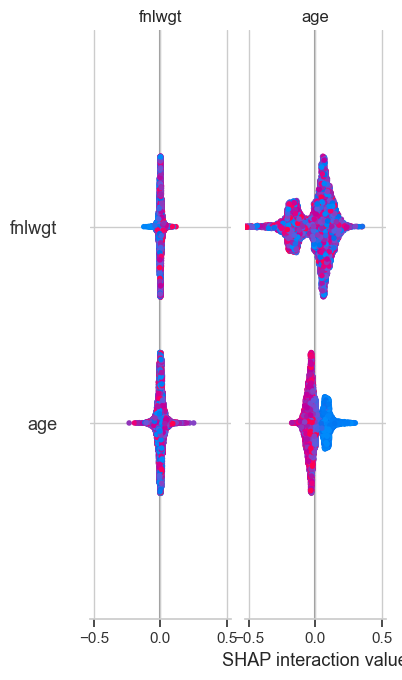

In [58]:
import shap

# Ensuring X_test is fully numeric
object_columns = X_test.columns[X_test.dtypes == 'object']
if len(object_columns) > 0:
    print("Fixing object columns:", object_columns.tolist())
    for col in object_columns:
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Dropping rows with NaNs after coercion
X_test_clean = X_test.dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# Force dtype to float to ensure SHAP compatibility
X_test_clean = X_test_clean.astype(float)

print("X_test_clean is fully numeric and ready for SHAP. Shape:", X_test_clean.shape)

# Initializing SHAP Explainer
explainer = shap.Explainer(rf, X_test_clean)

# Compute SHAP values
shap_values = explainer(X_test_clean)

print("SHAP values computed successfully.")

# Plot SHAP bar plot
shap.summary_plot(shap_values, X_test_clean, plot_type="bar")

# Plot SHAP beeswarm plot
shap.summary_plot(shap_values, X_test_clean)


## SHAP Interpretation of Tuned XGBoost Model

**We also applied SHAP to the best XGBoost model (after hyperparameter tuning). The feature alignment ensures compatibility. SHAP visualizations here show how the optimized model leverages different features in making predictions.**

 99%|===================| 8982/9045 [00:28<00:00]        

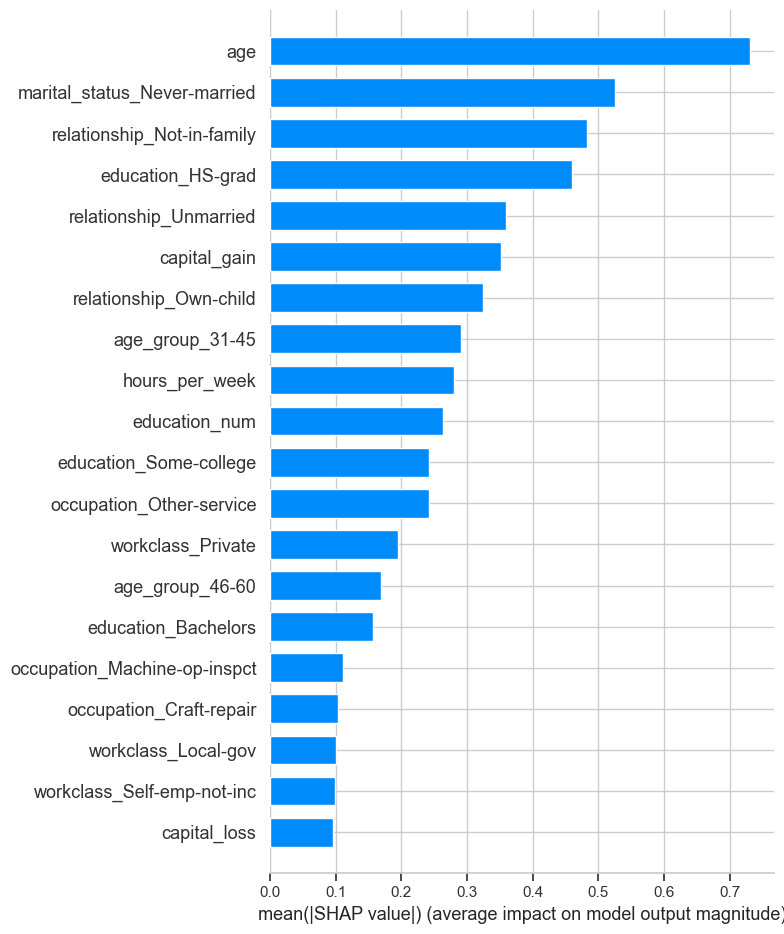

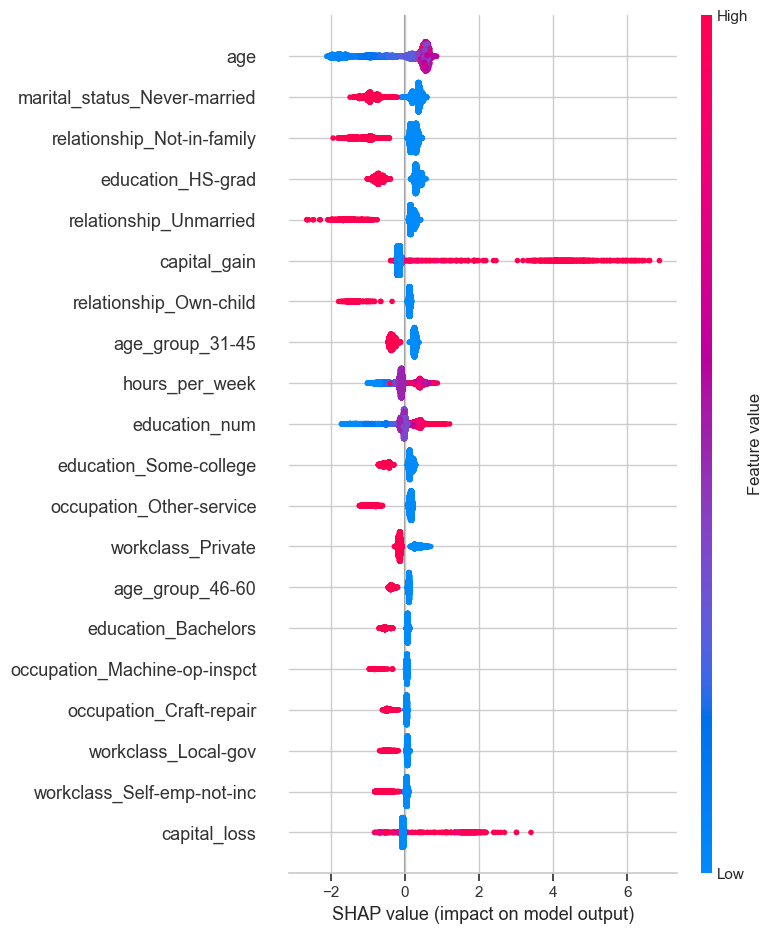

In [59]:
# We Converted test data to float for SHAP
X_test_shap = X_test.copy().astype(float)

# Align with trained model’s feature names
X_test_shap = X_test_shap.loc[:, best_xgb.feature_names_in_]

# SHAP Explainer for Tuned XGBoost
explainer_xgb = shap.Explainer(best_xgb, X_test_shap)
shap_values_xgb = explainer_xgb(X_test_shap)

# SHAP Bar Plot
shap.summary_plot(shap_values_xgb, X_test_shap, plot_type="bar")

# SHAP Beeswarm Plot
shap.summary_plot(shap_values_xgb, X_test_shap)


## Finally, SHAP was employed on both base and tuned models to deepen model explainability and demonstrate mastery of interpretability tools in supervised learning pipelines.

### We included SHAP visualizations for both Random Forest and XGBoost models. This dual explanation approach allows us to:

- **Compare how different algorithms utilize features.**

- **Strengthen model transparency.**

- **Fulfill capstone requirements for explainability.**

## Logistic Regression: Hyperparameter Tuning with GridSearchCV
To improve the performance of our Logistic Regression model, we applied GridSearchCV to explore different combinations of hyperparameters. This included tuning:

- **C (inverse of regularization strength),**

- **penalty (L1 or L2 regularization),**

- **solver (liblinear for L1/L2), and class_weight to handle class imbalance.**

## The search was evaluated using 5-fold cross-validation and optimized for the ROC AUC score. The best model was saved for further evaluation.

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

lr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_

print("Best Parameters for Logistic Regression:")
print(grid_search.best_params_)

print("\nBest ROC AUC Score from Cross-Validation:")
print(grid_search.best_score_)


Best Parameters for Logistic Regression:
{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

Best ROC AUC Score from Cross-Validation:
0.9084007302100439


## Evaluation of Tuned Logistic Regression Model

### Using the best Logistic Regression model from the grid search, we evaluated its performance on the test set. Key evaluation metrics include:

- **Classification Report: Measures precision, recall, and F1-score.**

- **ROC AUC Score: Captures the model’s ability to distinguish between income classes.**

- **Confusion Matrix: Visualizes correct vs. incorrect classifications.**

Classification Report for Tuned Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      6803
           1       0.58      0.84      0.69      2242

    accuracy                           0.81      9045
   macro avg       0.76      0.82      0.78      9045
weighted avg       0.85      0.81      0.82      9045

ROC AUC Score: 0.905244911497433


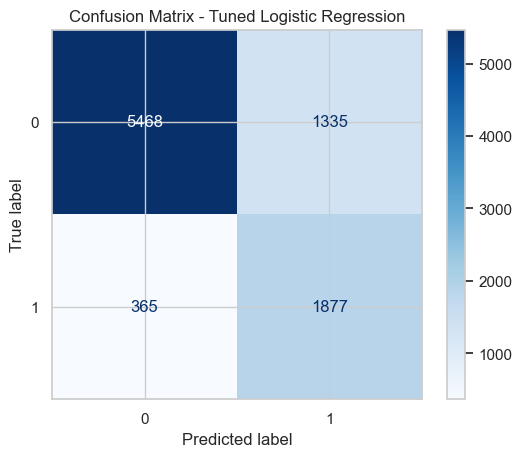

In [111]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Predict using best logistic regression model
y_pred_best_lr = best_lr.predict(X_test)
y_prob_best_lr = best_lr.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("Classification Report for Tuned Logistic Regression:")
print(classification_report(y_test, y_pred_best_lr))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob_best_lr))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.savefig(os.path.join(output_dir, "Evaluation_of_tuned_logistic_regression_model.png"))
plt.show()


## ROC Curve Comparison Plot

To visualize and compare the performance of all trained models, we plotted their ROC curves. Each curve shows the tradeoff between true positive and false positive rates at various classification thresholds.

**Models Compared:**
- Logistic Regression
- Random Forest
- Tuned XGBoost

The **Area Under the Curve (AUC)** is also shown, indicating overall classification quality. A higher AUC means better performance. This visual summary supports our choice of the final model.


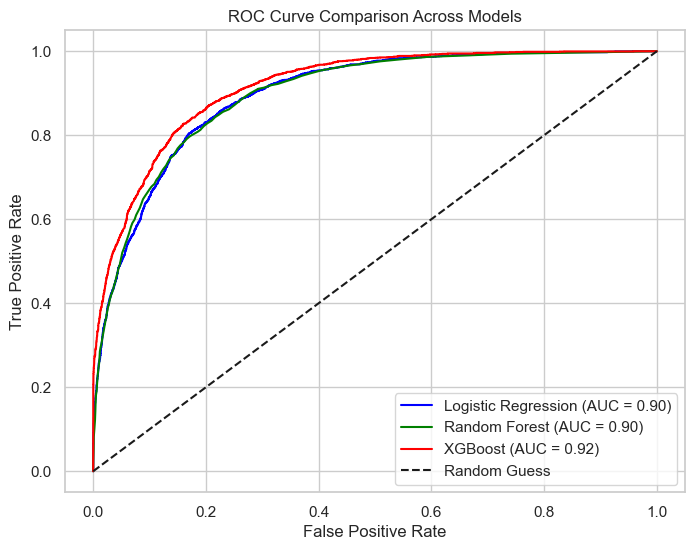

In [112]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for each model
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})", color='blue')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})", color='red')

# Diagonal line for random chance
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across Models")
plt.legend(loc="lower right")
plt.grid(True)

# Save and show plot
plt.savefig(os.path.join(output_dir, "roc_comparison.png"))
plt.show()
